### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

# Optim
from chestxray.optimizers import RAdam

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


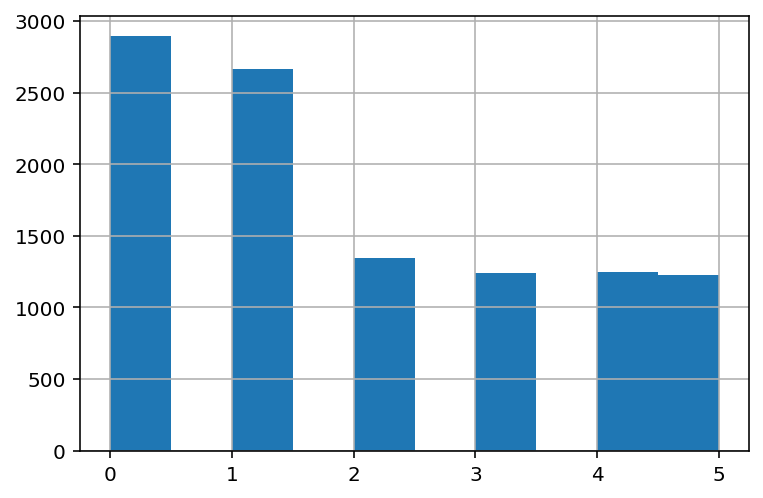

In [8]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [9]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
print(EXP_NAME)

21-05-2020-15-12


In [10]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

In [9]:
# # if resume should continue previous writer
# PREV_NAME = "21-05-2020-15-12"
# writer = SummaryWriter(f'runs/{PREV_NAME}')

In [9]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

In [10]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmRestarts, not epoch_type),
    "none": (None, None)
}

### Train Eval Loop

In [11]:
def train_eval_loop(train_dataloader, val_dataloader, model, optimizer, criterion, scheduler, sch_is_epoch_type, accum_step=CFG.accum_step, checkpoint=False,
                    num_epochs=CFG.epoch, device=device, tb_tag="", model_name="debug"):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step)
    
    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=step, dataformats="HWC")
        del img
    
    def preds_to_tb(outputs, inputs, labels, step):
        figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu'))
        writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step)
    
    def text_preds_to_tb(outputs, labels, step):
        preds_text = text_classes_preds(outputs.to("cpu"), labels.to("cpu"))
        writer.add_text(f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step)
        
    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(f"On best {mode} save:", 
                        f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}", 
                        global_step=step)
    
    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds),
                          global_step=step)
        
        
    
    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()
    
    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp: # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
    # define epochs numbers to look into input images and predictions, no more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint['best_qwk']
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]
    
    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)

        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        
        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            if (i+1)% accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # loss is mean across batch, divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
            # Add Batch Type Scheduler step here:
            if scheduler and not sch_is_epoch_type:
                scheduler.step()
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)
        
        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(tag=f"lr Interim {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
            writer.add_scalar(tag=f"lr Classifier {tb_tag}:", scalar_value=optimizer.param_groups[1]["lr"], global_step=train_global_step)
            
        else:
            writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_qwk': best_qwk,
            }, f'{MODEL_PATH}/{model_name}_loss.pth')
            # add losses as text to TB
            metrics_to_tb("loss", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_qwk': best_qwk,
            }, f'{MODEL_PATH}/{model_name}_qwk.pth')
            # add losses and qwk as text to TB
            metrics_to_tb("qwk", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)  
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
    # End of loop
    writer.close()

### Prepare CV - strategy

In [12]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [13]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [14]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       100 non-null    object
 1   data_provider  100 non-null    object
 2   isup_grade     100 non-null    int64 
 3   gleason_score  100 non-null    object
 4   fold           100 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


### Debug Runs

In [15]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [16]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 1024 img_width: 1024 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 16 tile_sz: 256 batch_size: 4 accum_step: 16 dataset: hdf5 aug_type: light finetune: False model_cls: one_layer schedule_type: none cawr_T: 1 cawr_Tmult: 2 loss: cce optim: adam lr: 0.0001 rlopp: 3 epoch: 70 n_fold: 4 use_amp: True


In [17]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [18]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    if schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])
    if schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

In [19]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, debug=False)
    val_ds = PatchTrainDataset(val_df, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patches500.h5"])
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    val_ds = train_ds
else:
    print(f"No such dataset {CFG.dataset}")

# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=1, pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=1, pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)

model_ft = PatchModel()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, num_epochs=20)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


 13%|█▎        | 16/125 [00:04<00:28,  3.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 77%|███████▋  | 96/125 [00:25<00:07,  3.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.20it/s]


Training Loss: 1.6961	Validation Loss: 1.3562
Counter train preds: Counter({0: 303, 1: 124, 2: 61, 3: 8, 5: 3, 4: 1})	Counter val preds: Counter({0: 199, 1: 129, 2: 79, 5: 51, 4: 25, 3: 17})
Epoch train QWK: 0.071	val QWK: 0.482
  Epoch 0 - Save Best Loss: 1.3562 Model
Confusion matrix, without normalization
[[100  18   4   1   0   3]
 [ 37  77  14   0   3   5]
 [ 19  15  25   1   4   7]
 [ 13   5  18   8   0   4]
 [ 15  11  17   4  16   5]
 [ 15   3   1   3   2  27]]
  Epoch 0 - Save Best QWK: 0.4820 Model
Confusion matrix, without normalization
[[100  18   4   1   0   3]
 [ 37  77  14   0   3   5]
 [ 19  15  25   1   4   7]
 [ 13   5  18   8   0   4]
 [ 15  11  17   4  16   5]
 [ 15   3   1   3   2  27]]
Epoch 1/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


Training Loss: 1.4177	Validation Loss: 1.0833
Counter train preds: Counter({0: 177, 1: 151, 2: 75, 5: 46, 4: 36, 3: 15})	Counter val preds: Counter({0: 166, 1: 100, 4: 80, 5: 74, 2: 62, 3: 18})
Epoch train QWK: 0.442	val QWK: 0.720
  Epoch 1 - Save Best Loss: 1.0833 Model
Confusion matrix, without normalization
[[113   3   0   0   8   2]
 [ 32  82  10   0   7   5]
 [ 10   7  36   1   7  10]
 [  4   2   7  16  12   7]
 [  3   4   9   1  41  10]
 [  4   2   0   0   5  40]]
  Epoch 1 - Save Best QWK: 0.7199 Model
Confusion matrix, without normalization
[[113   3   0   0   8   2]
 [ 32  82  10   0   7   5]
 [ 10   7  36   1   7  10]
 [  4   2   7  16  12   7]
 [  3   4   9   1  41  10]
 [  4   2   0   0   5  40]]
Epoch 2/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.03it/s]


Training Loss: 1.1816	Validation Loss: 0.8396
Counter train preds: Counter({0: 184, 1: 122, 2: 70, 5: 57, 4: 48, 3: 19})	Counter val preds: Counter({0: 170, 1: 123, 5: 70, 4: 59, 2: 55, 3: 23})
Epoch train QWK: 0.590	val QWK: 0.803
  Epoch 2 - Save Best Loss: 0.8396 Model
Confusion matrix, without normalization
[[123   0   0   0   2   1]
 [ 20 110   1   0   3   2]
 [ 11   8  43   1   3   5]
 [  7   3   4  21   4   9]
 [  5   2   6   1  45   9]
 [  4   0   1   0   2  44]]
  Epoch 2 - Save Best QWK: 0.8028 Model
Confusion matrix, without normalization
[[123   0   0   0   2   1]
 [ 20 110   1   0   3   2]
 [ 11   8  43   1   3   5]
 [  7   3   4  21   4   9]
 [  5   2   6   1  45   9]
 [  4   0   1   0   2  44]]
Epoch 3/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.00it/s]


Training Loss: 1.0395	Validation Loss: 0.6663
Counter train preds: Counter({0: 168, 1: 156, 2: 60, 5: 56, 4: 40, 3: 20})	Counter val preds: Counter({1: 147, 0: 138, 5: 66, 2: 62, 4: 57, 3: 30})
Epoch train QWK: 0.680	val QWK: 0.890
  Epoch 3 - Save Best Loss: 0.6663 Model
Confusion matrix, without normalization
[[123   2   0   0   1   0]
 [  0 134   0   1   1   0]
 [  5   6  54   1   1   4]
 [  6   2   4  27   3   6]
 [  3   3   3   1  49   9]
 [  1   0   1   0   2  47]]
  Epoch 3 - Save Best QWK: 0.8903 Model
Confusion matrix, without normalization
[[123   2   0   0   1   0]
 [  0 134   0   1   1   0]
 [  5   6  54   1   1   4]
 [  6   2   4  27   3   6]
 [  3   3   3   1  49   9]
 [  1   0   1   0   2  47]]
Epoch 4/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.19it/s]


Training Loss: 0.9074	Validation Loss: 0.4801
Counter train preds: Counter({0: 155, 1: 152, 2: 71, 4: 50, 5: 49, 3: 23})	Counter val preds: Counter({0: 133, 1: 133, 2: 68, 4: 67, 5: 62, 3: 37})
Epoch train QWK: 0.754	val QWK: 0.940
  Epoch 4 - Save Best Loss: 0.4801 Model
Confusion matrix, without normalization
[[123   1   0   0   1   1]
 [  5 127   2   1   1   0]
 [  2   3  63   0   1   2]
 [  2   1   2  35   3   5]
 [  1   1   1   1  61   3]
 [  0   0   0   0   0  51]]
  Epoch 4 - Save Best QWK: 0.9404 Model
Confusion matrix, without normalization
[[123   1   0   0   1   1]
 [  5 127   2   1   1   0]
 [  2   3  63   0   1   2]
 [  2   1   2  35   3   5]
 [  1   1   1   1  61   3]
 [  0   0   0   0   0  51]]
Epoch 5/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.07it/s]


Training Loss: 0.7693	Validation Loss: 0.3636
Counter train preds: Counter({0: 153, 1: 151, 2: 62, 4: 54, 5: 47, 3: 33})	Counter val preds: Counter({1: 133, 0: 129, 4: 71, 2: 70, 5: 54, 3: 43})
Epoch train QWK: 0.780	val QWK: 0.977
  Epoch 5 - Save Best Loss: 0.3636 Model
Confusion matrix, without normalization
[[125   0   0   0   1   0]
 [  3 131   1   0   0   1]
 [  1   1  67   0   2   0]
 [  0   1   1  43   2   1]
 [  0   0   1   0  66   1]
 [  0   0   0   0   0  51]]
  Epoch 5 - Save Best QWK: 0.9774 Model
Confusion matrix, without normalization
[[125   0   0   0   1   0]
 [  3 131   1   0   0   1]
 [  1   1  67   0   2   0]
 [  0   1   1  43   2   1]
 [  0   0   1   0  66   1]
 [  0   0   0   0   0  51]]
Epoch 6/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.76it/s]


Training Loss: 0.6031	Validation Loss: 0.2834
Counter train preds: Counter({1: 147, 0: 135, 2: 69, 4: 63, 5: 50, 3: 36})	Counter val preds: Counter({1: 135, 0: 126, 2: 71, 4: 66, 5: 56, 3: 46})
Epoch train QWK: 0.891	val QWK: 0.989
  Epoch 6 - Save Best Loss: 0.2834 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 135   1   0   0   0]
 [  0   0  69   0   0   2]
 [  0   0   0  46   0   2]
 [  0   0   1   0  66   1]
 [  0   0   0   0   0  51]]
  Epoch 6 - Save Best QWK: 0.9888 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 135   1   0   0   0]
 [  0   0  69   0   0   2]
 [  0   0   0  46   0   2]
 [  0   0   1   0  66   1]
 [  0   0   0   0   0  51]]
Epoch 7/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.66it/s]


Training Loss: 0.5679	Validation Loss: 0.1768
Counter train preds: Counter({1: 158, 0: 124, 2: 69, 4: 62, 5: 51, 3: 36})	Counter val preds: Counter({1: 137, 0: 126, 2: 72, 4: 67, 5: 51, 3: 47})
Epoch train QWK: 0.883	val QWK: 0.997
  Epoch 7 - Save Best Loss: 0.1768 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   1   0  47   0   0]
 [  0   0   1   0  67   0]
 [  0   0   0   0   0  51]]
  Epoch 7 - Save Best QWK: 0.9972 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   1   0  47   0   0]
 [  0   0   1   0  67   0]
 [  0   0   0   0   0  51]]
Epoch 8/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.92it/s]


Training Loss: 0.4894	Validation Loss: 0.1257
Counter train preds: Counter({1: 149, 0: 133, 4: 68, 2: 63, 5: 48, 3: 39})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.932	val QWK: 1.000
  Epoch 8 - Save Best Loss: 0.1257 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
  Epoch 8 - Save Best QWK: 1.0000 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 9/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.88it/s]


Training Loss: 0.4029	Validation Loss: 0.0795
Counter train preds: Counter({1: 137, 0: 131, 2: 72, 4: 64, 5: 49, 3: 47})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.952	val QWK: 1.000
  Epoch 9 - Save Best Loss: 0.0795 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 10/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.00it/s]


Training Loss: 0.3184	Validation Loss: 0.0648
Counter train preds: Counter({1: 144, 0: 129, 2: 69, 4: 66, 5: 51, 3: 41})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.964	val QWK: 1.000
  Epoch 10 - Save Best Loss: 0.0648 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 11/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.85it/s]


Training Loss: 0.2865	Validation Loss: 0.0570
Counter train preds: Counter({1: 136, 0: 133, 2: 71, 4: 68, 5: 50, 3: 42})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.958	val QWK: 1.000
  Epoch 11 - Save Best Loss: 0.0570 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 12/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.15it/s]


Training Loss: 0.2564	Validation Loss: 0.0332
Counter train preds: Counter({1: 137, 0: 134, 2: 68, 4: 62, 3: 50, 5: 49})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.939	val QWK: 1.000
  Epoch 12 - Save Best Loss: 0.0332 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 13/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.00it/s]

Training Loss: 0.2271	Validation Loss: 0.0383
Counter train preds: Counter({1: 139, 0: 128, 2: 70, 4: 66, 5: 49, 3: 48})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.970	val QWK: 1.000
Epoch 14/19



  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:10<00:00, 12.11it/s]


Training Loss: 0.2187	Validation Loss: 0.0261
Counter train preds: Counter({1: 135, 0: 129, 2: 71, 4: 71, 3: 48, 5: 46})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.954	val QWK: 1.000
  Epoch 14 - Save Best Loss: 0.0261 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 15/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 13.06it/s]

Training Loss: 0.1831	Validation Loss: 0.0276
Counter train preds: Counter({1: 135, 0: 129, 2: 70, 4: 67, 5: 51, 3: 48})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.981	val QWK: 1.000
Epoch 16/19



  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.96it/s]


Training Loss: 0.1886	Validation Loss: 0.0206
Counter train preds: Counter({1: 142, 0: 121, 4: 70, 2: 70, 5: 49, 3: 48})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.981	val QWK: 1.000
  Epoch 16 - Save Best Loss: 0.0206 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]
Epoch 17/19


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.83it/s]

Training Loss: 0.1741	Validation Loss: 0.0225
Counter train preds: Counter({1: 131, 0: 128, 2: 74, 4: 69, 5: 51, 3: 47})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.977	val QWK: 1.000
Epoch 18/19



  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.90it/s]

Training Loss: 0.1868	Validation Loss: 0.0233
Counter train preds: Counter({1: 141, 0: 127, 4: 68, 2: 67, 5: 51, 3: 46})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.983	val QWK: 1.000
Epoch 19/19



  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


  0%|          | 0/125 [00:00<?, ?it/s]

Add file 0 to cache


100%|██████████| 125/125 [00:09<00:00, 12.99it/s]


Training Loss: 0.1793	Validation Loss: 0.0164
Counter train preds: Counter({1: 139, 0: 123, 2: 72, 4: 67, 5: 51, 3: 48})	Counter val preds: Counter({1: 136, 0: 126, 2: 71, 4: 68, 5: 51, 3: 48})
Epoch train QWK: 0.985	val QWK: 1.000
  Epoch 19 - Save Best Loss: 0.0164 Model
Confusion matrix, without normalization
[[126   0   0   0   0   0]
 [  0 136   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  48   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  51]]


### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


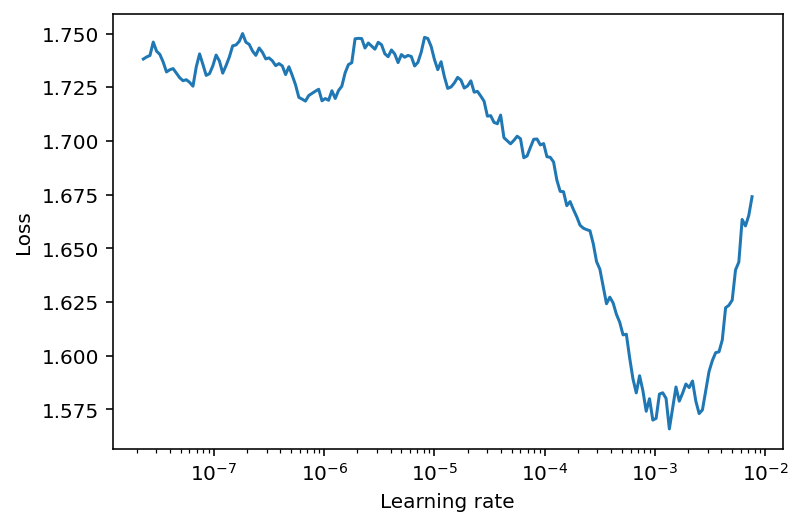

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

In [18]:
10e-5 == 1e-4

True

#### Experiment

In [19]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 256
 img_width: 256
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 20
 tile_sz: 256
 batch_size: 4
 accum_step: 8
 dataset: patch
 aug_type: light
 finetune: False
 model_cls: one_layer
 schedule_type: none
 cawr_T: 1
 cawr_Tmult: 2
 loss: ls_soft_ce
 optim: adam
 lr: 0.0001
 rlopp: 3
 epoch: 40
 n_fold: 4
 use_amp: True



In [20]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [18]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

In [22]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/39


  0%|          | 8/1991 [00:04<14:49,  2.23it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  1%|          | 24/1991 [00:08<07:45,  4.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 23%|██▎       | 448/1991 [01:47<06:12,  4.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:26<00:00,  4.54it/s]


Training Loss: 1.6035	Validation Loss: 1.4785
Counter train preds: Counter({0: 3956, 1: 2218, 2: 551, 4: 503, 3: 424, 5: 310})	Counter val preds: Counter({0: 1067, 1: 509, 5: 468, 2: 304, 3: 204, 4: 102})
Epoch train QWK: 0.276	val QWK: 0.555
  Epoch 0 - Save Best Loss: 1.4785 Model
Confusion matrix, without normalization
[[563  97   6   4  25  28]
 [250 209 138  38   8  23]
 [ 71  82 107  49   3  23]
 [ 63  57  23  63  11  94]
 [ 65  38  17  27  32 134]
 [ 55  26  13  23  23 166]]
  Epoch 0 - Save Best QWK: 0.5547 Model
Confusion matrix, without normalization
[[563  97   6   4  25  28]
 [250 209 138  38   8  23]
 [ 71  82 107  49   3  23]
 [ 63  57  23  63  11  94]
 [ 65  38  17  27  32 134]
 [ 55  26  13  23  23 166]]
Epoch 1/39


  0%|          | 8/1991 [00:04<14:35,  2.27it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:29<00:00,  4.45it/s]


Training Loss: 1.4960	Validation Loss: 1.3691
Counter train preds: Counter({0: 2911, 1: 2727, 5: 880, 2: 540, 3: 482, 4: 422})	Counter val preds: Counter({1: 1084, 0: 1010, 5: 336, 4: 140, 3: 47, 2: 37})
Epoch train QWK: 0.474	val QWK: 0.575
  Epoch 1 - Save Best Loss: 1.3691 Model
Confusion matrix, without normalization
[[606 102   1   0   1  13]
 [166 475  17   2   2   4]
 [ 55 253   7   6   1  13]
 [ 60 110   9  21  33  78]
 [ 70  95   3   9  55  81]
 [ 53  49   0   9  48 147]]
  Epoch 1 - Save Best QWK: 0.5749 Model
Confusion matrix, without normalization
[[606 102   1   0   1  13]
 [166 475  17   2   2   4]
 [ 55 253   7   6   1  13]
 [ 60 110   9  21  33  78]
 [ 70  95   3   9  55  81]
 [ 53  49   0   9  48 147]]
Epoch 2/39


  0%|          | 8/1991 [00:04<13:57,  2.37it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 664/664 [02:31<00:00,  4.40it/s]


Training Loss: 1.4686	Validation Loss: 1.3614
Counter train preds: Counter({0: 3042, 1: 2411, 5: 948, 4: 691, 3: 451, 2: 419})	Counter val preds: Counter({0: 1226, 1: 689, 5: 309, 3: 240, 4: 147, 2: 43})
Epoch train QWK: 0.520	val QWK: 0.606
  Epoch 2 - Save Best Loss: 1.3614 Model
Confusion matrix, without normalization
[[681   9   1   0  23   9]
 [270 357  11  12  11   5]
 [ 72 180  21  53   6   3]
 [ 64  75   4 100  14  54]
 [ 84  51   3  36  52  87]
 [ 55  17   3  39  41 151]]
  Epoch 2 - Save Best QWK: 0.6057 Model
Confusion matrix, without normalization
[[681   9   1   0  23   9]
 [270 357  11  12  11   5]
 [ 72 180  21  53   6   3]
 [ 64  75   4 100  14  54]
 [ 84  51   3  36  52  87]
 [ 55  17   3  39  41 151]]
Epoch 3/39


100%|██████████| 664/664 [02:26<00:00,  4.54it/s]


Training Loss: 1.4227	Validation Loss: 1.3089
Counter train preds: Counter({0: 3092, 1: 2125, 5: 939, 2: 740, 3: 735, 4: 331})	Counter val preds: Counter({0: 1096, 1: 666, 5: 531, 2: 223, 4: 102, 3: 36})
Epoch train QWK: 0.547	val QWK: 0.673
  Epoch 3 - Save Best Loss: 1.3089 Model
Confusion matrix, without normalization
[[675  30   2   0   8   8]
 [198 379  75   4   4   6]
 [ 56 144  94  11   3  27]
 [ 52  65  29  15  15 135]
 [ 66  32  14   4  54 143]
 [ 49  16   9   2  18 212]]
  Epoch 3 - Save Best QWK: 0.6731 Model
Confusion matrix, without normalization
[[675  30   2   0   8   8]
 [198 379  75   4   4   6]
 [ 56 144  94  11   3  27]
 [ 52  65  29  15  15 135]
 [ 66  32  14   4  54 143]
 [ 49  16   9   2  18 212]]
Epoch 4/39


  0%|          | 8/1991 [00:03<12:04,  2.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 664/664 [02:21<00:00,  4.69it/s]

Training Loss: 1.4199	Validation Loss: 1.3386
Counter train preds: Counter({0: 2780, 1: 2633, 5: 1311, 3: 467, 4: 389, 2: 382})	Counter val preds: Counter({0: 926, 1: 636, 2: 495, 5: 459, 3: 72, 4: 66})
Epoch train QWK: 0.544	val QWK: 0.638
Epoch 5/39



100%|██████████| 664/664 [02:20<00:00,  4.71it/s]


Training Loss: 1.4042	Validation Loss: 1.2856
Counter train preds: Counter({0: 2884, 1: 2590, 5: 1066, 3: 569, 4: 442, 2: 411})	Counter val preds: Counter({0: 982, 1: 738, 5: 305, 4: 258, 3: 238, 2: 133})
Epoch train QWK: 0.546	val QWK: 0.674
  Epoch 5 - Save Best Loss: 1.2856 Model
Confusion matrix, without normalization
[[630  79   1   1   3   9]
 [140 443  55  12  14   2]
 [ 45 131  54  61  33  11]
 [ 54  45  13  83  68  48]
 [ 61  32   6  50  99  65]
 [ 52   8   4  31  41 170]]
  Epoch 5 - Save Best QWK: 0.6735 Model
Confusion matrix, without normalization
[[630  79   1   1   3   9]
 [140 443  55  12  14   2]
 [ 45 131  54  61  33  11]
 [ 54  45  13  83  68  48]
 [ 61  32   6  50  99  65]
 [ 52   8   4  31  41 170]]
Epoch 6/39


100%|██████████| 664/664 [02:20<00:00,  4.73it/s]

Training Loss: 1.3947	Validation Loss: 1.3460
Counter train preds: Counter({0: 2860, 1: 2166, 5: 1270, 3: 621, 2: 620, 4: 425})	Counter val preds: Counter({0: 995, 1: 688, 5: 444, 3: 254, 4: 163, 2: 110})
Epoch train QWK: 0.582	val QWK: 0.647
Epoch 7/39



100%|██████████| 664/664 [02:21<00:00,  4.70it/s]


Training Loss: 1.4058	Validation Loss: 1.2797
Counter train preds: Counter({0: 2887, 1: 2165, 5: 1019, 2: 835, 4: 592, 3: 464})	Counter val preds: Counter({0: 984, 1: 865, 5: 509, 4: 163, 2: 121, 3: 12})
Epoch train QWK: 0.544	val QWK: 0.700
  Epoch 7 - Save Best Loss: 1.2797 Model
Confusion matrix, without normalization
[[654  53   1   0   0  15]
 [153 481  17   1   4  10]
 [ 45 187  64   5  10  24]
 [ 50  78  25   3  52 103]
 [ 41  49   7   3  76 137]
 [ 41  17   7   0  21 220]]
  Epoch 7 - Save Best QWK: 0.6996 Model
Confusion matrix, without normalization
[[654  53   1   0   0  15]
 [153 481  17   1   4  10]
 [ 45 187  64   5  10  24]
 [ 50  78  25   3  52 103]
 [ 41  49   7   3  76 137]
 [ 41  17   7   0  21 220]]
Epoch 8/39


 62%|██████▏   | 1240/1991 [04:44<02:46,  4.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:20<00:00,  4.72it/s]


Training Loss: 1.3728	Validation Loss: 1.2753
Counter train preds: Counter({0: 2759, 1: 2490, 5: 1204, 3: 617, 4: 504, 2: 388})	Counter val preds: Counter({0: 978, 1: 828, 5: 407, 3: 231, 4: 123, 2: 87})
Epoch train QWK: 0.607	val QWK: 0.679
  Epoch 8 - Save Best Loss: 1.2753 Model
Confusion matrix, without normalization
[[649  32   1   1   7  33]
 [168 476   8   4   5   5]
 [ 39 204  36  40   8   8]
 [ 41  67  26  84  21  72]
 [ 41  39  11  57  63 102]
 [ 40  10   5  45  19 187]]
Epoch 9/39


 56%|█████▌    | 1112/1991 [04:13<03:17,  4.44it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:21<00:00,  4.70it/s]


Training Loss: 1.3632	Validation Loss: 1.2637
Counter train preds: Counter({0: 2792, 1: 2630, 5: 913, 3: 553, 2: 546, 4: 528})	Counter val preds: Counter({0: 1098, 1: 911, 4: 238, 5: 221, 3: 142, 2: 44})
Epoch train QWK: 0.583	val QWK: 0.635
  Epoch 9 - Save Best Loss: 1.2637 Model
Confusion matrix, without normalization
[[695  23   0   0   3   2]
 [170 481   7   2   6   0]
 [ 47 234  20  15  13   6]
 [ 56  90  16  68  53  28]
 [ 65  57   1  31  97  62]
 [ 65  26   0  26  66 123]]
Epoch 10/39


  0%|          | 8/1991 [00:03<11:35,  2.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:20<00:00,  4.72it/s]


Training Loss: 1.3480	Validation Loss: 1.2530
Counter train preds: Counter({0: 2775, 1: 2561, 5: 1008, 4: 578, 2: 547, 3: 493})	Counter val preds: Counter({0: 1015, 1: 861, 4: 402, 3: 152, 5: 143, 2: 81})
Epoch train QWK: 0.615	val QWK: 0.674
  Epoch 10 - Save Best Loss: 1.2530 Model
Confusion matrix, without normalization
[[672  46   1   0   3   1]
 [126 513  16   7   4   0]
 [ 36 190  36  51  17   5]
 [ 55  71  14  62  82  27]
 [ 69  29  10  24 162  19]
 [ 57  12   4   8 134  91]]
Epoch 11/39


100%|██████████| 664/664 [02:20<00:00,  4.72it/s]

Training Loss: 1.3497	Validation Loss: 1.2679
Counter train preds: Counter({0: 2722, 1: 2554, 5: 1219, 4: 557, 3: 478, 2: 432})	Counter val preds: Counter({0: 1064, 1: 831, 5: 378, 4: 203, 3: 114, 2: 64})
Epoch train QWK: 0.624	val QWK: 0.659
Epoch 12/39



  0%|          | 8/1991 [00:03<12:05,  2.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:24<00:00,  4.61it/s]


Training Loss: 1.3386	Validation Loss: 1.3209
Counter train preds: Counter({0: 2762, 1: 2336, 5: 1185, 2: 605, 3: 597, 4: 477})	Counter val preds: Counter({0: 881, 5: 605, 1: 566, 2: 344, 3: 202, 4: 56})
Epoch train QWK: 0.624	val QWK: 0.716
  Epoch 12 - Save Best QWK: 0.7158 Model
Confusion matrix, without normalization
[[621  62   3   1  14  22]
 [131 364 142   9   8  12]
 [ 26  83 140  52   5  29]
 [ 37  27  36  74   5 132]
 [ 33  23  13  52  20 172]
 [ 33   7  10  14   4 238]]
Epoch 13/39


100%|██████████| 664/664 [02:29<00:00,  4.43it/s]


Training Loss: 1.3407	Validation Loss: 1.2463
Counter train preds: Counter({0: 2717, 1: 2606, 5: 930, 4: 650, 2: 574, 3: 485})	Counter val preds: Counter({0: 969, 1: 738, 5: 318, 3: 233, 4: 218, 2: 178})
Epoch train QWK: 0.597	val QWK: 0.703
  Epoch 13 - Save Best Loss: 1.2463 Model
Confusion matrix, without normalization
[[666  28   5   3  12   9]
 [146 455  27  24  10   4]
 [ 30 173  73  38  14   7]
 [ 39  49  42  86  43  52]
 [ 52  26  15  46  84  90]
 [ 36   7  16  36  55 156]]
Epoch 14/39


100%|██████████| 664/664 [02:23<00:00,  4.62it/s]


Training Loss: 1.3271	Validation Loss: 1.2281
Counter train preds: Counter({0: 2760, 1: 2417, 3: 876, 5: 842, 4: 582, 2: 485})	Counter val preds: Counter({0: 990, 1: 776, 5: 292, 4: 256, 3: 173, 2: 167})
Epoch train QWK: 0.625	val QWK: 0.705
  Epoch 14 - Save Best Loss: 1.2281 Model
Confusion matrix, without normalization
[[670  46   1   1   1   4]
 [139 464  41  18   4   0]
 [ 38 163  80  23  15  16]
 [ 48  53  29  62  51  68]
 [ 52  36  12  50 119  44]
 [ 43  14   4  19  66 160]]
Epoch 15/39


  0%|          | 8/1991 [00:03<12:35,  2.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:27<00:00,  4.50it/s]

Training Loss: 1.3338	Validation Loss: 1.2473
Counter train preds: Counter({0: 2612, 1: 2409, 5: 872, 3: 865, 4: 707, 2: 497})	Counter val preds: Counter({0: 835, 1: 818, 3: 393, 4: 368, 5: 128, 2: 112})
Epoch train QWK: 0.634	val QWK: 0.703
Epoch 16/39



 66%|██████▌   | 1312/1991 [05:18<02:43,  4.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:25<00:00,  4.58it/s]


Training Loss: 1.3129	Validation Loss: 1.2241
Counter train preds: Counter({0: 2733, 1: 2181, 5: 1036, 2: 707, 3: 673, 4: 632})	Counter val preds: Counter({0: 1022, 1: 622, 2: 300, 5: 282, 4: 265, 3: 163})
Epoch train QWK: 0.641	val QWK: 0.698
  Epoch 16 - Save Best Loss: 1.2241 Model
Confusion matrix, without normalization
[[677  20   7   0  13   6]
 [154 422  66  12  11   1]
 [ 47 125 110  33   8  12]
 [ 47  33  62  75  43  51]
 [ 52  16  35  25 125  60]
 [ 45   6  20  18  65 152]]
Epoch 17/39


100%|██████████| 664/664 [02:22<00:00,  4.65it/s]

Training Loss: 1.2982	Validation Loss: 1.2609
Counter train preds: Counter({0: 2757, 1: 2084, 2: 900, 5: 853, 3: 779, 4: 589})	Counter val preds: Counter({0: 897, 1: 831, 5: 395, 4: 222, 2: 176, 3: 133})
Epoch train QWK: 0.646	val QWK: 0.709
Epoch 18/39



 70%|███████   | 1400/1991 [05:38<02:14,  4.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:21<00:00,  4.68it/s]


Training Loss: 1.3142	Validation Loss: 1.2553
Counter train preds: Counter({0: 2687, 1: 2402, 5: 1156, 4: 637, 3: 613, 2: 467})	Counter val preds: Counter({0: 905, 1: 781, 5: 536, 2: 233, 3: 136, 4: 63})
Epoch train QWK: 0.646	val QWK: 0.716
  Epoch 18 - Save Best QWK: 0.7159 Model
Confusion matrix, without normalization
[[641  62   3   2   0  15]
 [107 483  52   9   3  12]
 [ 33 143 100  27  14  18]
 [ 42  55  45  64  16  89]
 [ 43  31  17  25  21 176]
 [ 39   7  16   9   9 226]]
Epoch 19/39


  0%|          | 8/1991 [00:05<17:42,  1.87it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:27<00:00,  4.49it/s]

Training Loss: 1.2749	Validation Loss: 1.2410
Counter train preds: Counter({0: 2644, 1: 2311, 5: 897, 2: 760, 4: 693, 3: 657})	Counter val preds: Counter({0: 958, 1: 929, 5: 297, 3: 214, 4: 188, 2: 68})
Epoch train QWK: 0.669	val QWK: 0.691
Epoch 20/39



100%|██████████| 664/664 [02:22<00:00,  4.67it/s]

Training Loss: 1.2857	Validation Loss: 1.2329
Counter train preds: Counter({0: 2825, 1: 2143, 5: 1018, 3: 790, 2: 694, 4: 492})	Counter val preds: Counter({0: 1032, 1: 795, 5: 384, 2: 196, 3: 171, 4: 76})
Epoch train QWK: 0.665	val QWK: 0.669
Epoch 21/39



  6%|▌         | 112/1991 [00:28<07:36,  4.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:20<00:00,  4.71it/s]


Training Loss: 1.2730	Validation Loss: 1.2054
Counter train preds: Counter({0: 2699, 1: 2457, 5: 849, 3: 764, 4: 743, 2: 450})	Counter val preds: Counter({0: 956, 1: 660, 4: 295, 2: 262, 5: 259, 3: 222})
Epoch train QWK: 0.659	val QWK: 0.736
  Epoch 21 - Save Best Loss: 1.2054 Model
Confusion matrix, without normalization
[[674  27   5   3   5   9]
 [143 433  60  21   5   4]
 [ 29 127 117  48   8   6]
 [ 37  39  43  94  46  52]
 [ 44  24  23  38 141  43]
 [ 29  10  14  18  90 145]]
  Epoch 21 - Save Best QWK: 0.7356 Model
Confusion matrix, without normalization
[[674  27   5   3   5   9]
 [143 433  60  21   5   4]
 [ 29 127 117  48   8   6]
 [ 37  39  43  94  46  52]
 [ 44  24  23  38 141  43]
 [ 29  10  14  18  90 145]]
Epoch 22/39


  2%|▏         | 48/1991 [00:14<07:48,  4.15it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:26<00:00,  4.54it/s]


Training Loss: 1.2898	Validation Loss: 1.2700
Counter train preds: Counter({0: 2661, 1: 2253, 4: 875, 5: 782, 2: 775, 3: 616})	Counter val preds: Counter({0: 731, 1: 697, 5: 440, 2: 344, 3: 280, 4: 162})
Epoch train QWK: 0.652	val QWK: 0.737
  Epoch 22 - Save Best QWK: 0.7371 Model
Confusion matrix, without normalization
[[554 126   3  16  11  13]
 [ 75 426 118  39   5   3]
 [ 20  83 150  58   7  17]
 [ 30  25  42 100  27  87]
 [ 29  27  22  46  80 109]
 [ 23  10   9  21  32 211]]
Epoch 23/39


100%|██████████| 664/664 [02:21<00:00,  4.68it/s]

Training Loss: 1.2813	Validation Loss: 1.2171
Counter train preds: Counter({0: 2665, 1: 2314, 5: 937, 4: 748, 3: 722, 2: 576})	Counter val preds: Counter({1: 863, 0: 834, 4: 378, 5: 302, 2: 236, 3: 41})
Epoch train QWK: 0.672	val QWK: 0.729
Epoch 24/39



  0%|          | 8/1991 [00:04<14:54,  2.22it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:21<00:00,  4.70it/s]

Training Loss: 1.2673	Validation Loss: 1.2580
Counter train preds: Counter({0: 2600, 1: 2221, 5: 982, 4: 794, 2: 693, 3: 672})	Counter val preds: Counter({0: 957, 1: 692, 5: 397, 4: 316, 2: 206, 3: 86})
Epoch train QWK: 0.684	val QWK: 0.702
Epoch 25/39



100%|██████████| 664/664 [02:24<00:00,  4.58it/s]

Training Loss: 1.2578	Validation Loss: 1.3557
Counter train preds: Counter({0: 2649, 1: 2225, 5: 984, 4: 960, 2: 775, 3: 369})	Counter val preds: Counter({0: 931, 5: 657, 1: 557, 4: 215, 3: 155, 2: 139})
Epoch train QWK: 0.694	val QWK: 0.725
Epoch 26/39



 33%|███▎      | 648/1991 [02:42<05:08,  4.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:21<00:00,  4.71it/s]


Training Loss: 1.2480	Validation Loss: 1.1857
Counter train preds: Counter({0: 2453, 1: 2139, 2: 996, 5: 989, 4: 732, 3: 653})	Counter val preds: Counter({0: 1005, 1: 698, 4: 265, 5: 264, 3: 249, 2: 173})
Epoch train QWK: 0.702	val QWK: 0.723
  Epoch 26 - Save Best Loss: 1.1857 Model
Confusion matrix, without normalization
[[682  30   1   0   3   7]
 [145 459  41  13   6   2]
 [ 41 138  81  48  22   5]
 [ 44  43  28  98  65  33]
 [ 49  26  14  48 124  52]
 [ 44   2   8  42  45 165]]
Epoch 27/39


100%|██████████| 664/664 [02:22<00:00,  4.66it/s]

Training Loss: 1.2340	Validation Loss: 1.2042
Counter train preds: Counter({0: 2513, 1: 2317, 2: 861, 5: 860, 4: 709, 3: 702})	Counter val preds: Counter({0: 999, 1: 697, 4: 329, 5: 300, 2: 174, 3: 155})
Epoch train QWK: 0.698	val QWK: 0.733
Epoch 28/39



  0%|          | 8/1991 [00:04<14:19,  2.31it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:21<00:00,  4.70it/s]

Training Loss: 1.2486	Validation Loss: 1.2032
Counter train preds: Counter({0: 2466, 1: 2404, 4: 901, 5: 891, 3: 793, 2: 507})	Counter val preds: Counter({1: 914, 0: 907, 5: 448, 4: 132, 2: 130, 3: 123})
Epoch train QWK: 0.698	val QWK: 0.722
Epoch 29/39



  0%|          | 8/1991 [00:03<12:45,  2.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:21<00:00,  4.70it/s]


Training Loss: 1.2353	Validation Loss: 1.1944
Counter train preds: Counter({0: 2561, 1: 2213, 5: 989, 2: 914, 4: 716, 3: 569})	Counter val preds: Counter({0: 883, 1: 713, 4: 363, 5: 325, 3: 228, 2: 142})
Epoch train QWK: 0.697	val QWK: 0.740
  Epoch 29 - Save Best QWK: 0.7397 Model
Confusion matrix, without normalization
[[641  43   1   0  19  19]
 [128 466  39  17  12   4]
 [ 23 142  68  64  20  18]
 [ 28  37  20  95  71  60]
 [ 38  21  10  31 155  58]
 [ 25   4   4  21  86 166]]
Epoch 30/39


  0%|          | 8/1991 [00:03<13:10,  2.51it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:20<00:00,  4.73it/s]

Training Loss: 1.2307	Validation Loss: 1.2239
Counter train preds: Counter({0: 2466, 1: 2368, 5: 1006, 3: 862, 4: 632, 2: 628})	Counter val preds: Counter({1: 970, 0: 866, 5: 301, 3: 181, 4: 168, 2: 168})
Epoch train QWK: 0.694	val QWK: 0.708
Epoch 31/39



100%|██████████| 664/664 [02:19<00:00,  4.76it/s]


Training Loss: 1.2078	Validation Loss: 1.1962
Counter train preds: Counter({0: 2637, 1: 2264, 5: 894, 2: 839, 4: 671, 3: 657})	Counter val preds: Counter({1: 901, 0: 826, 5: 364, 2: 245, 4: 188, 3: 130})
Epoch train QWK: 0.718	val QWK: 0.747
  Epoch 31 - Save Best QWK: 0.7471 Model
Confusion matrix, without normalization
[[620  89   1   0   4   9]
 [ 88 538  31   2   5   2]
 [ 27 167 105  18   4  14]
 [ 35  56  66  59  33  62]
 [ 27  40  29  33 102  82]
 [ 29  11  13  18  40 195]]
Epoch 32/39


100%|██████████| 664/664 [02:19<00:00,  4.77it/s]


Training Loss: 1.2020	Validation Loss: 1.1854
Counter train preds: Counter({0: 2498, 1: 2444, 5: 1080, 2: 719, 3: 679, 4: 542})	Counter val preds: Counter({0: 822, 1: 788, 4: 324, 5: 281, 3: 233, 2: 206})
Epoch train QWK: 0.707	val QWK: 0.769
  Epoch 32 - Save Best Loss: 1.1854 Model
Confusion matrix, without normalization
[[638  63   2   4  13   3]
 [ 80 516  39  21   9   1]
 [ 25 151  92  35  12  20]
 [ 30  29  47  91  58  56]
 [ 24  25  19  51 149  45]
 [ 25   4   7  31  83 156]]
  Epoch 32 - Save Best QWK: 0.7695 Model
Confusion matrix, without normalization
[[638  63   2   4  13   3]
 [ 80 516  39  21   9   1]
 [ 25 151  92  35  12  20]
 [ 30  29  47  91  58  56]
 [ 24  25  19  51 149  45]
 [ 25   4   7  31  83 156]]
Epoch 33/39


  6%|▌         | 112/1991 [00:27<07:05,  4.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:19<00:00,  4.75it/s]

Training Loss: 1.1976	Validation Loss: 1.2801
Counter train preds: Counter({0: 2529, 1: 2313, 5: 883, 4: 805, 2: 778, 3: 654})	Counter val preds: Counter({1: 954, 0: 851, 5: 384, 3: 187, 4: 169, 2: 109})
Epoch train QWK: 0.718	val QWK: 0.652
Epoch 34/39



  0%|          | 8/1991 [00:03<12:18,  2.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:20<00:00,  4.74it/s]

Training Loss: 1.2088	Validation Loss: 1.1984
Counter train preds: Counter({0: 2545, 1: 2487, 5: 885, 4: 699, 3: 693, 2: 653})	Counter val preds: Counter({0: 848, 1: 759, 5: 331, 4: 277, 2: 275, 3: 164})
Epoch train QWK: 0.710	val QWK: 0.753
Epoch 35/39



100%|██████████| 664/664 [02:21<00:00,  4.69it/s]

Training Loss: 1.2086	Validation Loss: 1.1950
Counter train preds: Counter({0: 2667, 1: 2166, 4: 839, 3: 822, 2: 818, 5: 650})	Counter val preds: Counter({0: 826, 1: 774, 5: 383, 3: 256, 4: 254, 2: 161})
Epoch train QWK: 0.690	val QWK: 0.748
Epoch 36/39



  0%|          | 8/1991 [00:03<13:34,  2.44it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:21<00:00,  4.70it/s]


Training Loss: 1.1834	Validation Loss: 1.1888
Counter train preds: Counter({0: 2578, 1: 2274, 5: 1033, 3: 744, 2: 732, 4: 601})	Counter val preds: Counter({0: 960, 1: 720, 5: 405, 2: 246, 4: 181, 3: 142})
Epoch train QWK: 0.717	val QWK: 0.743
Epoch 37/39


 38%|███▊      | 752/1991 [03:04<04:42,  4.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:25<00:00,  4.57it/s]

Training Loss: 1.1664	Validation Loss: 1.2020
Counter train preds: Counter({0: 2566, 1: 2252, 5: 807, 3: 800, 2: 777, 4: 760})	Counter val preds: Counter({1: 950, 0: 835, 4: 240, 5: 231, 3: 212, 2: 186})
Epoch train QWK: 0.723	val QWK: 0.713
Epoch 38/39



100%|██████████| 664/664 [02:23<00:00,  4.64it/s]

Training Loss: 1.1745	Validation Loss: 1.2443
Counter train preds: Counter({0: 2409, 1: 2347, 2: 926, 5: 793, 3: 787, 4: 700})	Counter val preds: Counter({0: 932, 1: 754, 2: 291, 5: 289, 4: 270, 3: 118})
Epoch train QWK: 0.732	val QWK: 0.720
Epoch 39/39



100%|██████████| 664/664 [02:21<00:00,  4.71it/s]

Training Loss: 1.1722	Validation Loss: 1.2147
Counter train preds: Counter({0: 2437, 1: 2228, 5: 1015, 2: 894, 4: 772, 3: 616})	Counter val preds: Counter({0: 886, 1: 675, 5: 396, 2: 281, 4: 245, 3: 171})
Epoch train QWK: 0.728	val QWK: 0.747


#### Resume Training

In [23]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, debug=False)
    val_ds = PatchTrainDataset(val_df, debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 10), pin_memory=True)


checkpoint = torch.load(f'{MODEL_PATH}/{PREV_NAME}_loss.pth')

model_ft = Model(arch="resnet34")
model_ft.load_state_dict(checkpoint['model_state_dict'])
model_ft.to(device)
criterion = LOSSES[CFG.loss]

if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# set smaller lr here
for param_group in optimizer.param_groups:
        param_group['lr'] = CFG.lr / 10

scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=True)

In [24]:
train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=PREV_NAME, checkpoint=checkpoint)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 42/69


  6%|▌         | 112/1991 [00:28<06:35,  4.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 97%|█████████▋| 1936/1991 [07:33<00:12,  4.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:23<00:00,  4.63it/s]

Training Loss: 1.0242	Validation Loss: 1.1500
Counter train preds: Counter({0: 2374, 1: 2223, 5: 944, 3: 823, 2: 823, 4: 775})	Counter val preds: Counter({0: 857, 1: 776, 5: 357, 2: 247, 4: 228, 3: 189})
Epoch train QWK: 0.821	val QWK: 0.767
Epoch 43/69



100%|██████████| 664/664 [02:23<00:00,  4.64it/s]

Training Loss: 1.0048	Validation Loss: 1.1754
Counter train preds: Counter({0: 2385, 1: 2274, 5: 1002, 2: 808, 3: 769, 4: 724})	Counter val preds: Counter({0: 887, 1: 774, 5: 443, 2: 232, 4: 174, 3: 144})
Epoch train QWK: 0.826	val QWK: 0.764
Epoch 44/69



 34%|███▍      | 680/1991 [02:41<04:43,  4.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:23<00:00,  4.62it/s]

Training Loss: 0.9964	Validation Loss: 1.1647
Counter train preds: Counter({0: 2323, 1: 2256, 5: 972, 2: 901, 4: 772, 3: 738})	Counter val preds: Counter({0: 830, 1: 746, 2: 399, 5: 315, 4: 222, 3: 142})
Epoch train QWK: 0.829	val QWK: 0.761
Epoch 45/69



 98%|█████████▊| 1944/1991 [10:22<00:19,  2.40it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 664/664 [02:33<00:00,  4.32it/s]

Training Loss: 0.9951	Validation Loss: 1.1545
Counter train preds: Counter({0: 2382, 1: 2189, 2: 893, 5: 888, 4: 860, 3: 750})	Counter val preds: Counter({0: 916, 1: 762, 5: 309, 3: 231, 4: 220, 2: 216})
Epoch train QWK: 0.827	val QWK: 0.756
Epoch 46/69



 63%|██████▎   | 1264/1991 [05:07<02:50,  4.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:28<00:00,  4.48it/s]

Training Loss: 0.9811	Validation Loss: 1.1511
Counter train preds: Counter({0: 2383, 1: 2240, 5: 858, 4: 850, 2: 833, 3: 798})	Counter val preds: Counter({0: 923, 1: 691, 2: 277, 4: 270, 5: 264, 3: 229})
Epoch train QWK: 0.830	val QWK: 0.770
Epoch 47/69



100%|██████████| 664/664 [02:22<00:00,  4.67it/s]


Training Loss: 0.9774	Validation Loss: 1.1689
Counter train preds: Counter({0: 2386, 1: 2184, 5: 1003, 2: 872, 3: 785, 4: 732})	Counter val preds: Counter({0: 924, 1: 723, 5: 358, 2: 275, 4: 230, 3: 144})
Epoch train QWK: 0.833	val QWK: 0.766
Epoch 48/69


  0%|          | 9/1991 [00:02<08:48,  3.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:21<00:00,  4.70it/s]

Training Loss: 0.9715	Validation Loss: 1.1707
Counter train preds: Counter({0: 2372, 1: 2192, 5: 935, 2: 877, 4: 822, 3: 764})	Counter val preds: Counter({0: 888, 1: 769, 5: 322, 2: 279, 4: 267, 3: 129})
Epoch train QWK: 0.838	val QWK: 0.767
Epoch 49/69



 31%|███       | 617/1991 [02:18<04:37,  4.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:20<00:00,  4.73it/s]


Training Loss: 0.9653	Validation Loss: 1.1681
Counter train preds: Counter({0: 2375, 1: 2139, 5: 1003, 2: 914, 4: 821, 3: 710})	Counter val preds: Counter({0: 907, 1: 651, 5: 381, 2: 283, 4: 220, 3: 212})
Epoch train QWK: 0.842	val QWK: 0.774
  Epoch 49 - Save Best QWK: 0.7735 Model
Confusion matrix, without normalization
[[667  40   6   0   3   7]
 [115 457  73  10   8   3]
 [ 22 117 128  42  10  16]
 [ 35  19  48 102  48  59]
 [ 37  13  21  37 115  90]
 [ 31   5   7  21  36 206]]
Epoch 50/69


  0%|          | 9/1991 [00:03<09:34,  3.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:21<00:00,  4.69it/s]

Training Loss: 0.9539	Validation Loss: 1.1952
Counter train preds: Counter({0: 2316, 1: 2189, 5: 956, 2: 907, 4: 892, 3: 702})	Counter val preds: Counter({0: 949, 1: 781, 5: 327, 4: 235, 3: 201, 2: 161})
Epoch train QWK: 0.852	val QWK: 0.738
Epoch 51/69



100%|██████████| 664/664 [02:22<00:00,  4.66it/s]


Training Loss: 0.9425	Validation Loss: 1.1649
Counter train preds: Counter({0: 2293, 1: 2180, 5: 969, 2: 961, 4: 819, 3: 740})	Counter val preds: Counter({0: 888, 1: 707, 4: 327, 5: 316, 2: 244, 3: 172})
Epoch train QWK: 0.844	val QWK: 0.776
  Epoch 51 - Save Best QWK: 0.7756 Model
Confusion matrix, without normalization
[[659  49   1   0   7   7]
 [113 473  61   8   8   3]
 [ 22 136 114  31  17  15]
 [ 35  25  42  87  74  48]
 [ 31  18  18  30 157  59]
 [ 28   6   8  16  64 184]]
Epoch 52/69


 19%|█▉        | 376/1991 [01:29<06:02,  4.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:24<00:00,  4.61it/s]

Training Loss: 0.9375	Validation Loss: 1.1874
Counter train preds: Counter({0: 2353, 1: 2113, 2: 999, 5: 920, 4: 878, 3: 699})	Counter val preds: Counter({0: 946, 1: 727, 5: 339, 2: 272, 4: 224, 3: 146})
Epoch train QWK: 0.857	val QWK: 0.746
Epoch 53/69



  0%|          | 8/1991 [00:03<10:56,  3.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:26<00:00,  4.54it/s]

Training Loss: 0.9320	Validation Loss: 1.1796
Counter train preds: Counter({0: 2342, 1: 2113, 5: 961, 2: 933, 4: 874, 3: 739})	Counter val preds: Counter({0: 878, 1: 715, 5: 407, 2: 281, 4: 204, 3: 169})
Epoch train QWK: 0.847	val QWK: 0.760
Epoch 54/69



100%|██████████| 664/664 [02:23<00:00,  4.61it/s]

Training Loss: 0.9323	Validation Loss: 1.1785
Counter train preds: Counter({0: 2321, 1: 2114, 2: 1030, 4: 918, 5: 835, 3: 744})	Counter val preds: Counter({0: 912, 1: 649, 5: 304, 4: 289, 2: 263, 3: 237})
Epoch train QWK: 0.846	val QWK: 0.771
Epoch 55/69



  0%|          | 8/1991 [00:02<10:15,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:26<00:00,  4.52it/s]

Training Loss: 0.9163	Validation Loss: 1.1703
Counter train preds: Counter({0: 2321, 1: 2101, 2: 972, 5: 946, 4: 823, 3: 799})	Counter val preds: Counter({0: 939, 1: 634, 2: 361, 5: 287, 4: 237, 3: 196})
Epoch train QWK: 0.868	val QWK: 0.761
Epoch 56/69



 53%|█████▎    | 1052/1991 [10:27<09:19,  1.68it/s]


KeyboardInterrupt: 

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
